In [ ]:
#Collaborative Filtering is usually with Matrix Factorization.

#How to model Recommendation as a Neural Network?

#A neural network is for modeling complex interactions between entities.
#In our problem we have 2 entity.User and Jester.

#How can we vectorize user ?
#Ratings matrix is a good data for modeling a user by his likes.
#So we have a user vector of 100 items.

#***Here not reviewed jesters could lead some miss leading results.
#But we can also think these as Dropout. So even our model can benefit from this.
#I tried this approach also,it had good results but 
#then i decided to replace missing values with average of each user to get a embedding.
#this gave better results. But I also think this add some bias towards mean of users.
#We can exclude some items from set and try testing with some rated items excluded from training set.


#How can we model a jester?

#In fact that are latent features we don't know for Jester.
#Example Jester could be political, or about marriage,daily life...
#So we must find a way to vectorize Jester.

#Rating is 24933 user by 100 Jester matrix.
#If I transpose this then it becomes
#100 jester by 24933 user.
#This becomes an encoding for Jester based on user like.

#In fact we can use this, but dimension is so high.
#I tried 2 approaches, 
#Encode jesters by cosine, 
#Then I have a 100x100 matrix of Jester.This matrix shows how similar that one jester to others.

#Encode jesters by user , i chosed 50 dimension for PCA,Isomap
#Isomap a nonlinear dimension reduction so instead of having a jester
#mapping as 24933 dimension, we will just have 50 dimension.
#Then I have a 100x50 matrix of Jester.This matrix shows an encoding based on user like

#I trained both models, both are good, Isomapis better, since it is exactly encoding
#of what we want.

#Conclusion :
#I have a val_mean_absolute_error: 0.2 
#My values range from -1 to 1.
#so my error is 100 x 0.2 / 2 = 10
#So i can claim to guess what rating will user give to a jester with 90 accuracy.
#my guess will be around actual value by %10 ratio 



In [ ]:
#!pip install xlrd
#!pip install opt_einsum

!pip install keras

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity 
import matplotlib.pyplot as plt
import math
import keras
from keras.layers import Embedding, Flatten, Dense, Dropout, concatenate, multiply, Input
from keras.models import Sequential, Model
import numpy as np
from sklearn.model_selection import RepeatedKFold
from keras.callbacks import EarlyStopping


In [ ]:
#read the whole data 
#so i normalize data from range [-10,10] to range [-1,1] 
def normalize_by10(x):
    return x / 10

def denormalize_by10(x):
    return x * 10

#read excel
df_orig = pd.read_csv("jester-data-1.csv",index_col=None)

#drop 1st column which is for how many items rated by user
#replace 99 with None for easy manupulation
#normalize data by dividing to 10 so i have -1 to 1 distribution.
#data distribution seems nice,so i don't touch, i could try normalize by z value , 
df_normalized = df_orig.applymap(lambda x: None if x == 99 else x ).applymap(normalize_by10)
print("number of people:",len(df_normalized))
#display sample
df_normalized.head(5)

number of people: 24983


,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,Joke40,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,-0.782,0.879,-0.966,-0.816,-0.752,-0.850,-0.985,0.417,-0.898,-0.476,-0.850,-0.675,-0.718,0.845,-0.718,-0.752,-0.743,-0.981,-0.985,-0.985,-0.937,0.150,-0.437,-0.981,-0.850,0.112,0.782,0.286,0.913,-0.743,0.214,-0.408,-0.908,0.782,0.505,0.495,-0.917,-0.840,-0.840,-0.840,...,0.859,0.359,-0.684,-0.903,0.282,-0.136,-0.908,0.830,0.568,-0.481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.942,NaN,NaN,NaN,-0.772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.282,NaN,NaN,NaN,NaN,NaN,-0.563,NaN,NaN,NaN
1,0.408,-0.029,0.636,0.437,-0.238,-0.966,-0.073,-0.534,0.888,0.922,0.675,0.864,0.442,0.743,0.456,-0.097,0.466,-0.068,0.330,-0.121,0.087,0.864,0.835,0.917,0.005,0.757,0.471,0.087,-0.039,0.699,0.650,-0.092,0.714,0.903,-0.180,0.073,0.709,0.340,-0.087,0.791,...,-0.670,-0.335,-0.903,0.447,0.408,-0.383,0.874,0.112,0.078,0.752,-0.5,0.277,0.83,0.777,0.733,0.621,0.772,0.898,0.864,0.820,0.393,0.485,0.485,0.607,0.898,0.451,-0.005,0.369,0.456,0.058,0.282,-0.495,-0.029,0.786,-0.019,-0.214,0.306,0.034,-0.432,0.107
2,NaN,NaN,NaN,NaN,0.903,0.927,0.903,0.927,NaN,NaN,0.733,0.757,0.937,0.617,-0.636,-0.689,-0.786,0.903,0.903,0.903,0.728,NaN,0.825,NaN,NaN,0.748,0.728,0.728,0.893,NaN,0.617,0.728,NaN,NaN,0.898,0.733,NaN,0.617,0.908,0.733,...,0.646,0.728,NaN,NaN,0.704,0.728,NaN,0.728,0.825,NaN,NaN,NaN,NaN,NaN,NaN,0.893,NaN,NaN,NaN,0.908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.903,NaN,NaN,NaN,0.908,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.835,NaN,NaN,0.180,0.816,-0.282,0.621,NaN,0.184,0.733,0.660,0.631,0.811,-0.723,-0.665,0.117,-0.660,-0.364,-0.209,0.534,NaN,NaN,NaN,NaN,0.291,0.393,0.675,0.660,NaN,0.665,-0.612,NaN,0.757,0.621,0.665,NaN,-0.830,0.718,0.282,...,0.000,-0.369,NaN,NaN,0.782,0.024,NaN,0.728,-0.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063,NaN,NaN,-0.233,NaN,NaN,NaN,NaN,NaN,0.053,NaN,NaN,NaN,NaN,NaN,NaN
4,0.850,0.461,-0.417,-0.539,0.136,0.160,0.704,0.461,-0.044,0.573,0.825,0.684,-0.393,0.723,-0.233,-0.966,0.272,-0.136,0.257,0.451,0.820,0.612,0.830,-0.126,0.777,0.189,-0.117,0.568,0.845,0.461,0.806,-0.947,0.728,0.568,0.248,0.320,-0.126,0.680,0.451,0.248,...,0.738,0.617,0.471,-0.228,0.738,0.456,0.714,0.422,0.301,0.383,NaN,NaN,NaN,NaN,NaN,NaN,0.413,NaN,NaN,NaN,0.524,0.592,0.087,0.728,0.393,-0.063,0.631,0.471,0.282,0.296,0.519,0.558,0.427,0.519,0.573,0.155,0.311,0.655,0.180,0.160


In [ ]:
#check counts of ratings ( just round to )
unique, counts = np.unique(df_normalized.drop([0], 1).applymap(lambda x: math.floor(x)), return_counts=True)
dict(zip(unique, counts))

In [ ]:
#check counts of ratings ( just round to )
unique, counts = np.unique(df_orig.drop([0], 1).applymap(lambda x: math.floor(x)), return_counts=True)
dict(zip(unique, counts))

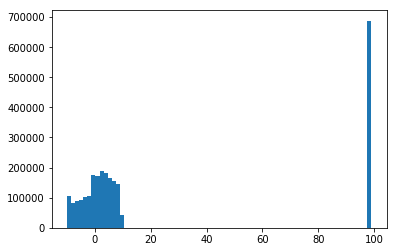

In [ ]:
#lets discover distribution of data
counts, bins = np.histogram( df_orig.drop([0], 1).values, bins='auto')
plt.hist(bins[:-1], bins, weights=counts)
plt.show()

In [ ]:
#it will encode users by jester and jester by users
df_user_jester = df_normalized
df_jester_user = df_user_jester.T
print( "df_user_jester shape :",df_user_jester.shape )
print( "df_jester_user shape :",df_jester_user.shape )

df_user_jester shape : (24983, 100)
df_jester_user shape : (100, 24983)


In [ ]:
#replace not commented 99(formerly replaced as NaN) with average of row
#average of row is, user's average like for jester set(of course not totally, it depends on which jester user rated )
df_jester_user_imputed =  df_jester_user.T.fillna(df_jester_user.mean(axis=1)).T
print( "df_jester_user_imputed shape :",df_jester_user_imputed.shape )
df_jester_user_imputed.head(5)

df_jester_user_imputed shape : (100, 24983)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,24943,24944,24945,24946,24947,24948,24949,24950,24951,24952,24953,24954,24955,24956,24957,24958,24959,24960,24961,24962,24963,24964,24965,24966,24967,24968,24969,24970,24971,24972,24973,24974,24975,24976,24977,24978,24979,24980,24981,24982
Joke1,-0.782,0.408,0.090457,0.090457,0.850,-0.617,0.090457,0.684,-0.379,0.301,-0.291000,0.131,0.090457,0.922,0.879,-0.350,0.090457,0.316,0.422000,0.090457,0.257000,0.728000,0.272,0.209,-0.393,0.090457,0.090457,0.049,0.090457,0.090457,0.194,0.090457,0.102,0.090457,0.592,-0.966000,0.718,-0.369000,0.296,0.090457,...,0.090457,0.090457,-0.544,0.090457,0.090457,0.090457,0.090457,-0.034,0.136,-0.544,0.090457,0.090457,-0.282,0.354,0.090457,-0.291,0.090457,0.090457,0.090457,0.485,0.816,-0.209,0.090457,0.413,-0.029,0.888,0.641,0.090457,0.417,0.090457,0.180000,0.090457,0.090457,0.136,0.090457,0.044,0.913,0.090457,0.090457,0.243
Joke2,0.879,-0.029,0.020846,0.835000,0.461,-0.354,0.020846,0.316,-0.354,0.515,0.408000,0.180,0.020846,0.927,-0.578,0.155,-0.927000,0.762,0.364000,0.762000,-0.073000,0.539000,0.417,-0.757,-0.117,0.549000,0.583000,0.015,0.020846,0.408000,0.087,0.568000,0.320,0.020846,-0.165,-0.835000,0.917,-0.112000,0.296,0.020846,...,0.020846,0.432000,0.704,0.020846,0.020846,0.020846,0.020846,0.859,0.456,0.388,0.020846,0.020846,-0.214,0.898,0.020846,-0.189,-0.748000,0.020846,0.020846,0.383,0.752,0.150,0.020846,0.913,-0.029,0.932,0.112,0.020846,0.417,0.020846,-0.942000,-0.922000,0.820000,0.175,0.020846,0.743,-0.816,0.020846,0.020846,0.267
Joke3,-0.966,0.636,0.031657,0.031657,-0.417,0.044,0.031657,0.917,-0.942,0.515,0.031657,0.257,0.031657,0.922,0.602,0.233,0.031657,0.379,0.031657,0.031657,0.031657,0.031657,0.650,0.417,0.228,0.345000,0.031657,0.015,0.031657,0.031657,0.141,0.568000,0.320,0.031657,0.592,0.031657,0.913,0.031657,0.296,0.031657,...,0.031657,0.031657,0.039,0.031657,0.031657,0.031657,0.031657,0.854,0.607,0.320,0.031657,0.031657,-0.330,0.680,0.031657,-0.286,0.031657,0.031657,0.031657,0.413,0.752,0.024,0.031657,0.723,-0.029,0.820,-0.515,0.031657,0.903,0.031657,-0.820000,0.031657,0.031657,0.238,0.031657,0.908,0.859,0.031657,0.031657,-0.398
Joke4,-0.816,0.437,-0.144911,-0.144911,-0.539,-0.850,-0.144911,-0.621,-0.689,0.301,-0.144911,-0.238,-0.144911,0.830,0.369,-0.413,-0.144911,0.825,-0.144911,-0.144911,-0.144911,-0.144911,-0.354,-0.840,-0.044,-0.144911,-0.144911,-0.956,-0.144911,-0.144911,0.296,-0.144911,0.286,-0.144911,0.587,-0.144911,0.374,-0.144911,0.296,-0.144911,...,-0.144911,-0.144911,-0.665,-0.144911,-0.144911,-0.144911,-0.144911,0.903,0.248,0.524,-0.144911,0.218000,-0.772,-0.121,-0.144911,-0.199,-0.144911,-0.144911,-0.144911,-0.553,0.816,-0.806,-0.144911,0.408,-0.029,0.340,-0.718,-0.144911,-0.029,-0.144911,-0.144911,-0.144911,-0.144911,0.184,-0.144911,0.233,0.908,-0.144911,-0.144911,0.427
Joke5,-0.752,-0.238,0.903000,0.180000,0.136,-0.709,0.859000,-0.816,-0.874,0.641,-0.573000,0.073,0.587000,0.743,0.777,0.422,-0.738000,0.422,0.252000,-0.864000,0.257000,-0.422000,-0.330,-0.631,-0.228,0.015000,0.534000,-0.976,-0.170000,0.587000,0.485,0.345000,0.238,-0.199000,0.306,0.029000,0.869,0.087000,0.374,-0.301000,...,0.068000,0.252000,0.568,0.558000,-0.262000,-0.951000,0.019000,0.175,0.417,0.024,-0.762000,0.354000,-0.102,0.811,0.379000,-0.752,-0.029000,0.039000,-0.252000,0.214,0.180,0.175,-0.670000,0.296,-0.184,0.044,-0.738,-0.010000,0.204,-0.602000,-0.854000,0.597000,0.879000,0.466,0.767000,0.320,0.087,-0.777000,-0.971000,-0.228


In [ ]:
#for changing row missing values, i transpose ,fill with mean and then transpose again
df_user_jester_imputed =  df_user_jester.T.fillna(df_user_jester.mean(axis=1)).T
print( "df_user_jester_imputed shape :",df_user_jester_imputed.shape )
df_user_jester_imputed.head(5)

df_user_jester_imputed shape : (24983, 100)


,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,Joke11,Joke12,Joke13,Joke14,Joke15,Joke16,Joke17,Joke18,Joke19,Joke20,Joke21,Joke22,Joke23,Joke24,Joke25,Joke26,Joke27,Joke28,Joke29,Joke30,Joke31,Joke32,Joke33,Joke34,Joke35,Joke36,Joke37,Joke38,Joke39,Joke40,...,Joke61,Joke62,Joke63,Joke64,Joke65,Joke66,Joke67,Joke68,Joke69,Joke70,Joke71,Joke72,Joke73,Joke74,Joke75,Joke76,Joke77,Joke78,Joke79,Joke80,Joke81,Joke82,Joke83,Joke84,Joke85,Joke86,Joke87,Joke88,Joke89,Joke90,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,-0.782000,0.879000,-0.966000,-0.816000,-0.752,-0.850,-0.985,0.417,-0.898000,-0.476000,-0.850,-0.675,-0.718,0.845,-0.718,-0.752,-0.743,-0.981,-0.985,-0.985,-0.937,0.150000,-0.437000,-0.981000,-0.850000,0.112,0.782,0.286,0.913,-0.743000,0.214,-0.408,-0.908000,0.782000,0.505,0.495,-0.917000,-0.840,-0.840,-0.840,...,0.859,0.359,-0.684000,-0.903000,0.282,-0.136,-0.908000,0.830,0.568,-0.481000,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.942000,-0.343189,-0.343189,-0.343189,-0.772000,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,0.282000,-0.343189,-0.343189,-0.343189,-0.343189,-0.343189,-0.563000,-0.343189,-0.343189,-0.343189
1,0.408000,-0.029000,0.636000,0.437000,-0.238,-0.966,-0.073,-0.534,0.888000,0.922000,0.675,0.864,0.442,0.743,0.456,-0.097,0.466,-0.068,0.330,-0.121,0.087,0.864000,0.835000,0.917000,0.005000,0.757,0.471,0.087,-0.039,0.699000,0.650,-0.092,0.714000,0.903000,-0.180,0.073,0.709000,0.340,-0.087,0.791,...,-0.670,-0.335,-0.903000,0.447000,0.408,-0.383,0.874000,0.112,0.078,0.752000,-0.500000,0.277000,0.830000,0.777000,0.733000,0.621000,0.772000,0.898000,0.864000,0.820000,0.393000,0.485000,0.485000,0.607000,0.898000,0.451000,-0.005000,0.369000,0.456000,0.058000,0.282000,-0.495000,-0.029000,0.786000,-0.019000,-0.214000,0.306000,0.034000,-0.432000,0.107000
2,0.709939,0.709939,0.709939,0.709939,0.903,0.927,0.903,0.927,0.709939,0.709939,0.733,0.757,0.937,0.617,-0.636,-0.689,-0.786,0.903,0.903,0.903,0.728,0.709939,0.825000,0.709939,0.709939,0.748,0.728,0.728,0.893,0.709939,0.617,0.728,0.709939,0.709939,0.898,0.733,0.709939,0.617,0.908,0.733,...,0.646,0.728,0.709939,0.709939,0.704,0.728,0.709939,0.728,0.825,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939,0.893000,0.709939,0.709939,0.709939,0.908000,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939,0.903000,0.709939,0.709939,0.709939,0.908000,0.709939,0.709939,0.709939,0.709939,0.709939,0.709939
3,0.265812,0.835000,0.265812,0.265812,0.180,0.816,-0.282,0.621,0.265812,0.184000,0.733,0.660,0.631,0.811,-0.723,-0.665,0.117,-0.660,-0.364,-0.209,0.534,0.265812,0.265812,0.265812,0.265812,0.291,0.393,0.675,0.660,0.265812,0.665,-0.612,0.265812,0.757000,0.621,0.665,0.265812,-0.830,0.718,0.282,...,0.000,-0.369,0.265812,0.265812,0.782,0.024,0.265812,0.728,-0.233,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812,0.063000,0.265812,0.265812,-0.233000,0.265812,0.265812,0.265812,0.265812,0.265812,0.053000,0.265812,0.265812,0.265812,0.265812,0.265812,0.265812
4,0.850000,0.461000,-0.417000,-0.539000,0.136,0.160,0.704,0.461,-0.044000,0.573000,0.825,0.684,-0.393,0.723,-0.233,-0.966,0.272,-0.136,0.257,0.451,0.820,0.612000,0.830000,-0.126000,0.777000,0.189,-0.117,0.568,0.845,0.461000,0.806,-0.947,0.728000,0.568000,0.248,0.320,-0.126000,0.680,0.451,0.248,...,0.738,0.617,0.471000,-0.228000,0.738,0.456,0.714000,0.422,0.301,0.383000,0.325264,0.325264,0.325264,0.325264,0.325264,0.325264,0.413000,0.325264,0.325264,0.325264,0.524000,0.592000,0.087000,0.728000,0.393000,-0.063000,0.631000,0.471000,0.282000,0.296000,0.519000,0.558000,0.427000,0.519000,0.573000,0.155000,0.311000,0.655000,0.180000,0.160000


In [ ]:
#create a cosine embedding for jesters
#this embedding is how similar each jester to other jesters
print("df_jester_user_imputed shape",df_jester_user_imputed.shape)
cosine_similarities = cosine_similarity(df_jester_user_imputed, df_jester_user_imputed) 
cosine_similarities.shape

df_jester_user_imputed shape (100, 24983)


(100, 100)

In [ ]:
#this is a similarity matrix, check diagonals are 1
#everything is totally similar to itself.
pd.DataFrame(cosine_similarities).head(100)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.363639,0.362482,0.192402,0.154229,0.241124,0.141009,0.122613,0.280543,0.343866,0.292132,0.244920,0.050988,0.218347,0.066105,-0.022194,0.001616,0.110595,0.098615,0.038640,0.210664,0.275131,0.264863,0.175947,0.285369,0.230035,0.236340,0.214076,0.246943,0.235750,0.251999,0.220136,0.218864,0.222910,0.259202,0.276477,0.238594,0.305752,0.213138,0.279080,...,0.230351,0.238206,0.239956,0.297300,0.198932,0.255275,0.199598,0.214292,0.260249,0.243534,0.045912,0.216050,0.139330,0.009875,0.063830,0.214939,0.114387,0.180988,0.079540,0.147563,0.219465,0.177717,0.198991,0.166628,0.176911,0.179264,0.258902,0.252021,0.218760,0.144276,0.211532,0.166561,0.239209,0.219170,0.202124,0.217806,0.218745,0.165215,0.120304,0.211604
1,0.363639,1.000000,0.281671,0.268723,0.178298,0.211195,0.166878,0.098297,0.225424,0.257425,0.260514,0.280741,0.133852,0.287288,0.095028,0.012448,0.098868,0.101937,0.088682,0.076862,0.249524,0.301717,0.242078,0.165570,0.389294,0.309720,0.177992,0.162781,0.261627,0.209489,0.263653,0.152657,0.255875,0.255080,0.225053,0.189586,0.262219,0.246518,0.266448,0.262189,...,0.203033,0.149975,0.230831,0.238602,0.202894,0.194049,0.191732,0.138748,0.241623,0.225618,0.073081,0.114654,0.097128,0.102224,0.064017,0.118830,0.067616,0.088841,0.065925,0.120565,0.162093,0.089818,0.132653,0.128194,0.147927,0.102775,0.132440,0.115208,0.076896,0.087005,0.112402,0.108836,0.120372,0.107698,0.109151,0.114361,0.126659,0.197690,0.104505,0.209245
2,0.362482,0.281671,1.000000,0.317075,0.181618,0.253264,0.140682,0.138792,0.293858,0.286815,0.380990,0.263713,0.097743,0.219071,0.084744,0.032972,0.092420,0.070947,0.122529,0.139125,0.211283,0.260005,0.304308,0.298190,0.264714,0.205573,0.184562,0.179345,0.177494,0.336876,0.207869,0.154050,0.367168,0.256030,0.180119,0.188219,0.241947,0.246051,0.230541,0.303167,...,0.210528,0.158764,0.206332,0.338917,0.195545,0.185858,0.230795,0.150301,0.186552,0.250876,0.079653,0.141754,0.155031,0.114864,0.150697,0.136781,0.141989,0.177789,0.151999,0.162291,0.172794,0.166557,0.162474,0.158878,0.172637,0.134459,0.156373,0.165257,0.118488,0.146586,0.143237,0.141169,0.156439,0.145266,0.166194,0.141315,0.142453,0.167087,0.143311,0.241857
3,0.192402,0.268723,0.317075,1.000000,0.130072,0.140820,0.175679,0.111144,0.380116,0.119030,0.126110,0.157628,0.210034,0.170663,0.170804,0.258480,0.284699,0.122104,0.139823,0.212868,0.112324,0.224731,0.247191,0.447672,0.280181,0.169804,-0.067110,0.088735,-0.047781,0.416633,0.037975,-0.070334,0.480614,0.207973,-0.043574,-0.091459,0.395563,0.116873,0.241583,0.192279,...,0.008071,-0.060486,0.211630,0.354086,0.055471,-0.008180,0.367764,-0.027200,-0.004972,0.264418,0.185115,-0.120031,0.091085,0.360021,0.284882,-0.092157,0.105306,-0.001078,0.182157,0.088767,-0.012280,0.078771,-0.008058,0.101443,0.113524,0.103430,-0.041062,-0.091680,-0.185529,0.116686,-0.062334,0.059819,-0.081025,0.031028,0.065239,0.012634,-0.010448,0.171852,0.218569,0.139905
4,0.154229,0.178298,0.181618,0.130072,1.000000,0.187275,0.193046,0.150185,0.080237,0.162414,0.252683,0.210549,0.114169,0.189815,0.097107,0.078974,0.201274,0.168380,0.247098,0.217840,0.273471,0.166154,0.122204,0.100882,0.188542,0.211825,0.263034,0.207736,0.205472,0.176230,0.276741,0.196054,0.133907,0.197906,0.233945,0.230251,0.058889,0.155687,0.242108,0.257089,...,0.244323,0.178404,0.129037,0.139588,0.211176,0.236258,0.088724,0.179371,0.206887,0.176891,0.047237,0.126730,0.151107,0.063790,0.077650,0.114144,0.120234,0.145324,0.122832,0.148503,0.140869,0.109376,0.150637,0.116482,0.162693,0.071269,0.124978,0.104612,0.101036,0.113189,0.109825,0.094893,0.117665,0.094127,0.100794,0.094611,0.096928,0.151462,0.094884,0.186813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
#our data is 25K rows x 100 colums
#for neural network i will use a 
#jester embeding + user embeding -> rating
#so i create a row for every cell
#this method return 25K x 100 = 2500K rows = 
def get_as_train_data(df_tabular,jester_encoding):    
    num_rows = len(df_tabular)    
    df_user_jester_values = df_tabular.values
    user_joke_rating = []
    y_rating = []
    for index_user in range(num_rows):    
        for joke_index,rating  in enumerate(df_tabular.iloc[index_user].values):        
            #if cell defined use it if not skip
            if not pd.isna( rating ):
                    
                jester_embedded = jester_encoding[joke_index]
                user_embedded  = df_user_jester_values[index_user:index_user+1,:].flatten()            
                                        
                embed_concat = np.hstack( (jester_embedded,user_embedded)).flatten()            
                y_rating.append(rating)                
                user_joke_rating.append(embed_concat)
                    
    return np.array(user_joke_rating),np.array(y_rating)

In [ ]:
#get a training set for cosine trial
x_train,y_train = get_as_train_data(df_user_jester_imputed,cosine_similarities)
print("x_train",x_train.shape)
print("y_train",y_train.shape)

x_train (2498300, 200)
y_train (2498300,)


In [ ]:
y_train[0:10]

array([-0.782,  0.879, -0.966, -0.816, -0.752, -0.85 , -0.985,  0.417,
       -0.898, -0.476])

In [ ]:
# from keras.optimizers import SGD
#I tried with different optimizations,different learning rates.
#below configurations seems good enough, it could try schedulers also
import tensorflow as tf
def mlp_model_cosine():
	# create model
	model = Sequential()
	model.add(Dense(120, input_dim=200, kernel_initializer='normal', activation='relu'))
	model.add(Dense(60, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
	model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])
    
	return model

def mlp_model_iso_deep():
	# create model
	model = Sequential()
	model.add(Dense(160, input_dim=150, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(80, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(40, kernel_initializer='normal', activation='relu'))
	model.add(Dropout(0.2))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	opt = keras.optimizers.Adam(lr=0.0001)
	model.compile(loss='mean_squared_logarithmic_error', optimizer=opt, metrics=['mean_absolute_error'])
    
	return model

In [ ]:
y_train[0]

-0.782

In [ ]:
#define cosine model and train,
# here we have train data as (2498300, 200) 
# 100 column jester embedding + 100 column user embedding
#use early stopping
model_cosine = mlp_model_cosine()

model_cosine.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 120)               24120     
                                                                 
 dense_7 (Dense)             (None, 60)                7260      
                                                                 
 dense_8 (Dense)             (None, 1)                 61        
                                                                 
Total params: 31,441
Trainable params: 31,441
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:


print("trainx",x_train.shape)
print("trainy",y_train.shape)
print(model_cosine.summary())
#if no improvement in 5 epoch more than 0.01 then quit training
#we could also use Model checkpoint to save best model
es = EarlyStopping(monitor='val_mean_absolute_error', mode='min', min_delta=0.01,patience=5)
history = model_cosine.fit(x_train,y_train,batch_size = 256,
                           shuffle=True,validation_split = 0.125,epochs = 50,verbose = 1,callbacks=[es])

trainx (2498300, 200)
trainy (2498300,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 120)               24120     
                                                                 
 dense_7 (Dense)             (None, 60)                7260      
                                                                 
 dense_8 (Dense)             (None, 1)                 61        
                                                                 
Total params: 31,441
Trainable params: 31,441
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
8540/8540 [==============================] - 29s 3ms/step - loss: 0.1369 - mean_absolute_error: 0.2711 - val_loss: 0.1390 - val_mean_absolute_error: 0.2703
Epoch 2/50
8540/8540 [==============================] - 28s 3ms/step - loss: 0.1285 - mean_absolute_er

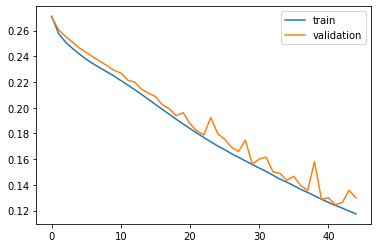

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['mean_absolute_error'], label='train')
pyplot.plot(history.history['val_mean_absolute_error'], label='validation')
pyplot.legend()
pyplot.show()
#seems validation begin fluctuating after 20-25 epoch,
#since this model is simple and no regularization(like dropout) it begins overfitting

In [ ]:
#this method is for preparing suggestiong by user
#model_trained : model trained
#user_index : which user we want to suggest for
#user_embeddings : source of user_embedding, we have only 1 type of embedding
#jester_embeddings : source of jester embedding, could be cosine or isomap
#
#return
#predictions : what will model predict for this user (for all 100 jester)
#df_all : just a  dataframe for checking results for all 100 jester
#df_suggestions : a  dataframe for checking results for only not rated items
#mean_abs_error : what will our model's absolute error be for this user

def get_user_preds(model_trained,user_index,user_embeddings,jester_embeddings,is_return_suggestions):
    #get user row values
    user_row =  user_embeddings.iloc[user_index].values
    #i want to also know Nan values
    normalized_row = df_normalized.iloc[user_index].values
    #create jester + user embeddings for predictions for all combinations    
    all_predict_input = []
    for i in range(len(jester_embeddings)):
        jester_embedded = jester_embeddings[i]
        embed_concat = np.hstack( (jester_embedded,user_row)).flatten()
        all_predict_input.append( embed_concat )
    #predict all movies for user(even ones which were rated before)    
    predictions = model_trained.predict(np.array(all_predict_input))
    
    actual_prediction = []
    abs_error = 0
    num_notnulls = 0
    status = []
    for i in range(len(jester_embedded)):
        #df_normalized has data with nan ,only add rated items to absolute error
        if not pd.isna(  normalized_row[i] ):
            status.append("Existing")
            num_notnulls += 1
            abs_error += abs(user_row[i] - predictions[i][0])
        else:
            status.append("New")
                                            
        actual_prediction.append([round(user_row[i],3) ,round(predictions[i][0],3) ])
    #mean absolute error for user
    mean_abs_error= abs_error / num_notnulls
    
    #I want to create a dataframe for predictions
    #Actual : Value in original file
    #Prediction : What will this network guess for this row
    #stat : status of cell, New means it is guessed rating, Existing means already rated
    df_all=pd.DataFrame(actual_prediction,columns=["actual","prediction"])
    #before we divide values by 10 ,now multiple 10 
    df_all = df_all.applymap(denormalize_by10)        
    df_all["status"] = status
    #also return suggestions as a 2nd dataframe
    df_suggestions = df_all[df_all["status"]=="New"]
    #sort suggestions
    df_suggestions = df_suggestions.sort_values('prediction',ascending=False)
    return predictions ,df_all ,df_suggestions,mean_abs_error
    



In [ ]:
predicted_data = []
for i in range(df_user_jester_imputed.shape[0]):

  predictions  ,df_all  ,df_suggestions,mean_abs_error= get_user_preds(model_cosine, i,df_user_jester_imputed,cosine_similarities,True)
  #check suggestions for user
  #here actual is average of user infact it is Nan
  # print("df_suggestions len",len(df_suggestions))
  # df_suggestions
  print(predictions.shape)
  predicted_data.append(predictions)



Streaming output truncated to the last 5000 lines.
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100

AttributeError: ignored

In [ ]:
p = np.array(predicted_data).reshape(-1, 100)
p.shape


(24983, 100)

In [ ]:
# jokes_array = np.array(jokes)
jokes_array = df_orig.values
n = jokes_array.shape[0]
m = jokes_array.shape[1]
sum_l2 = 0
count_l2 = 0
for i in range(n):
  for j in range(m):
    if(jokes_array[i][j]!=99):
      sum_l2 += np.square(predicted_data[i][j]-jokes_array[i][j])
      count_l2 += 1

In [ ]:
l2 = (sum_l2)/count_l2
print("L2 norm")
print(l2)

L2 norm
[17.88526752]


In [ ]:
#check all values for user
print("mean_abs_error for this user",round(mean_abs_error,2))
print(len(df_all))
print("existing predictions :",len(df_all[df_all["status"] == "Existing"]))
df_all[df_all["status"] == "Existing"]
#explanation of data for 1st row

#actual prediction stat
#3.01 4.09 Existing

#originally user rated 3.01
#if we had guessed the rating with our model we will guess as 4.09
#difference is nearly 1
#our values are between -10 and 10 
#so 1 error in 20 
# %5 error 

mean_abs_error for this user 0.18
100
existing predictions : 53


,actual,prediction,status
1,7.62,7.76,Existing
4,-8.64,-6.50,Existing
5,2.43,1.12,Existing
6,8.93,9.39,Existing
7,-6.60,-5.43,Existing
9,-9.47,-6.93,Existing
10,-2.77,-1.07,Existing
11,-0.73,-2.60,Existing
12,-9.27,-5.95,Existing
14,-1.02,-0.54,Existing


50

In [ ]:
print("df_jester_user_imputed shape:",df_jester_user_imputed.shape)

df_jester_user_imputed shape: (100, 24983)


In [ ]:
#kfold result
#so kfold absolute error is also 0.2
#since range is -1 to 1, it make %90 accuracy
sum(all_scores) / len(all_scores)